# FBProphet and Twitter Sentiment on Crypto

In [1]:
# Libraries
from eod import EodHistoricalData
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import twint
import nest_asyncio
nest_asyncio.apply()
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import numpy as np
import random
import plotly.express as px
from prophet import Prophet

# Importing and assigning the api key
with open("../../eodHistoricalData-API.txt", "r") as f:
    api_key = f.read()
    
# EOD Historical Data client
client = EodHistoricalData(api_key)

# Twitter Data

In [185]:
def getTweets(search_term, until, since, limit=20):
    """
    Configures Twint and returns a dataframe of tweets for a specific day.
    """
    # Configuring Twint for search
    c = twint.Config()

    # The limit of tweets to retrieve
    c.Limit = limit

    # Search term
    c.Search = search_term

    # Removing retweets
    c.Filter_retweets = True
    
    # Popular tweets
    c.Popular_tweets = True
    
    # Verified users only
    c.Verified = True

    # Lowercasing tweets
    c.Lowercase = False

    # English only
    c.Lang = 'en'

    # Tweets until a specified date
    c.Until = until + " 00:00:00"
    
    # Tweets since a specified date
    c.Since = since + " 00:00:00"
    
    # Making the results pandas friendly
    c.Pandas = True
    
    # Stopping print in terminal
    c.Hide_output = True

    # Searching
    twint.run.Search(c)
    
    # Assigning the DF
    df = twint.storage.panda.Tweets_df
    
    # Returning an empty DF if no tweets were found
    if len(df)<=0:
        return pd.DataFrame()
    
    # Formatting the date
    df['date'] = df['date'].apply(lambda x: x.split(" ")[0])
    
    # Returning with english filter to account for an issue with the twint language filter
    return df[df['language']=='en']

In [186]:
df = getTweets(
    "$BTC", 
    until="2022-02-17",
    since="2022-02-15",
    limit=20)

In [187]:
df

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1493733124081135616,1493733124081135616,1.644969e+12,2022-02-15,-0500,,"In Q4/2021, Warren Buffett's Berkshire Hathawa...",en,"[Bitcoin, BTC]",[BTC],...,,,,,,[],,,,
1,1493725558399803396,1493725558399803396,1.644967e+12,2022-02-15,-0500,,Pump $BTC while I'm sleeping👉👈 https://t.co/3...,en,[],[BTC],...,,,,,,[],,,,
2,1493719567948222464,1493719567948222464,1.644965e+12,2022-02-15,-0500,,"On this day one year ago, $BTC: $47,945.06 $E...",en,[],"[BTC, ETH, ADA, BNB, VET, AVAX, LUNA, SOL, DOG...",...,,,,,,[],,,,
3,1493710762812006400,1493710595215876097,1.644963e+12,2022-02-15,-0500,,@Bitcoin Buy #Bitcoin. Repeat.,en,[Bitcoin],[],...,,,,,,"[{'screen_name': 'Bitcoin', 'name': 'Bitcoin',...",,,,
4,1493703290168791044,1493703290168791044,1.644962e+12,2022-02-15,-0500,,"Gravity works like that, doesn't it? https:/...",en,[],[BTC],...,,,,,,[],,,,
5,1493696762862870531,1493696762862870531,1.644960e+12,2022-02-15,-0500,,MARKET WRAP: Altcoins rallied past bitcoin $BT...,en,[],[BTC],...,,,,,,[],,,,
6,1493687815535792135,1493687815535792135,1.644958e+12,2022-02-15,-0500,,Netflix is set to produce a documentary series...,en,"[Bitcoin, BTC]",[BTC],...,,,,,,[],,,,
7,1493676646922076162,1493616821907431426,1.644955e+12,2022-02-15,-0500,,@albarkati1 Why $600K? Is this based on the S2...,en,[],"[BTC, ETH, XRP]",...,,,,,,"[{'screen_name': 'albarkati1', 'name': 'Ashraf...",,,,
8,1493674037821771777,1493674037821771777,1.644955e+12,2022-02-15,-0500,,Coinbase Website Sees Massive Influx Of Visito...,en,[],"[COIN, CMCSA, BTC]",...,,,,,,[],,,,
9,1493666784855089157,1493666784855089157,1.644953e+12,2022-02-15,-0500,,"I spent a lot of time working on this, so if y...",en,[],[BTC],...,,,,,,[],,,,


## Using Twint

In [154]:
def tweetByDay(start, end, df, search, limit=20):
    """
    Runs the twint query everyday between the given dates and returns
    the total dataframe. 
    
    Start is the first date in the past.
    
    End is the last date (usually would be current date)
    """
    # Finishing the recursive loop
    if start==end:
        # Removing any potential duplicates
        df = df.drop_duplicates(subset="id")
        print(len(df))
        return df    
    
    # Appending the new set of tweets for specified window of time
    tweet_df = getTweets(
        search, 
        until=(datetime.strptime(start, "%Y-%m-%d") + timedelta(days=2)).strftime("%Y-%m-%d"), 
        since=start, 
        limit=limit
    )
    
    # Running the query a few more times in case twint missed some tweets
    run = 0 
    
    while len(tweet_df)==0 and run<=2:
        
        # Running query again
        tweet_df = getTweets(
            search, 
            until=(datetime.strptime(start, "%Y-%m-%d") + timedelta(days=2)).strftime("%Y-%m-%d"), 
            since=start, 
            limit=limit
        )
        
        # Counting how many times it ran
        run += 1
    
    # Adding the new tweets
    df = df.append(tweet_df, ignore_index=True)
    
    # Updating the new start date
    new_start = (datetime.strptime(start, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
        
    # Printing scraping status
    print(f"\t{len(df)} Total Tweets collected as of {new_start}\t")
    
    # Running the function again
    return tweetByDay(
        start=new_start, 
        end=end, 
        df=df, 
        search=search
    )

In [188]:
# Getting tweets daily
df = tweetByDay(
    start="2021-01-01", 
    end="2022-01-01", 
    df=pd.DataFrame(), 
    search="$BTC", 
    limit=20
)

	9 Total Tweets collected as of 2021-01-02	
	27 Total Tweets collected as of 2021-01-03	
	47 Total Tweets collected as of 2021-01-04	
	66 Total Tweets collected as of 2021-01-05	
	85 Total Tweets collected as of 2021-01-06	
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
	104 Total Tweets collected as of 2021-01-07	
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
	120 Total Tweets collected as of 2021-01-08	
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop

In [219]:
# Saving file for later use
df.to_csv("tweets.csv")

In [221]:
tweet_df = pd.read_csv("tweets.csv", index_col=0)

tweet_df

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,sentiment
0,1345146238706929664,1345146238706929664,1.609543e+12,2021-01-01,-500,NaN,Checking in on $BTC trading right now @Coinbas...,en,[],['BTC'],...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0.5719
1,1345141925519761428,1344775756417806336,1.609542e+12,2021-01-01,-500,NaN,@williamevanl @jbensnyder @alain_brutesque @je...,en,[],[],...,NaN,NaN,NaN,NaN,"[{'screen_name': 'williamevanl', 'name': 'Will...",NaN,NaN,NaN,NaN,0.3612
2,1345132699003056130,1345132699003056130,1.609540e+12,2021-01-01,-500,NaN,Have you seen our #Bitcoin Analytics Page? L...,en,"['Bitcoin', 'Crypto', 'Cryptocurrency', 'BTC']",['BTC'],...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0.2481
3,1345087911792930818,1345086392175624192,1.609529e+12,2021-01-01,-500,NaN,@EscoBartCaptial @lucasty007 He meant to say $...,en,[],"['XRP', 'BTC']",...,NaN,NaN,NaN,NaN,"[{'screen_name': 'lucasty007', 'name': 'luketh...",NaN,NaN,NaN,NaN,0.0000
4,1344996026848075777,1344996026848075777,1.609507e+12,2021-01-01,-500,NaN,Happy New Year! Good riddance to 2020 and here...,en,[],"['BTC', 'XBT']",...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0.9398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6062,1476916988261941248,1476916988261941248,1.640959e+12,2021-12-31,-500,NaN,Those that buy now will gain 1500% appreciatio...,en,[],['BTC'],...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0.7717
6063,1476914897791377410,1476914894582788100,1.640959e+12,2021-12-31,-500,NaN,Our new $100 million $BTC credit facility adds...,en,[],['BTC'],...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0.7184
6064,1476885687664263176,1476884136799444993,1.640952e+12,2021-12-31,-500,NaN,My overall take on crypto in 2021 is nobody ca...,en,[],"['BTC', 'ETH', 'SHIB']",...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0.8269
6065,1476870758831775744,1476870758831775744,1.640948e+12,2021-12-31,-500,NaN,2021 highlights: ✅ $BTC reached an ATH of USD6...,en,['Bitcoin'],"['BTC', 'BTC']",...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0.4588


# Sentiment Analysis on Tweets

In [190]:
def getSentiment(df, measurement="compound"):
    """
    Given a DF of tweets, analyzes the tweets and returns a new DF
    of sentiment scores based on the given measurement.
    Accepted sentiment measurements: ["pos", "neg", "neu", "compound"]
    """

    # Sentiment Analyzer
    sia = SentimentIntensityAnalyzer()

    # Getting the sentiment score
    df['sentiment'] = df['tweet'].apply(lambda x: sia.polarity_scores(x)[measurement])

    # Creating a DF with the average sentiment score each day
    sent_df = df.groupby('date')['sentiment'].mean().reset_index()
    
    # Converting the dates to datetime
    sent_df['date'] = sent_df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    
    # Setting the dates as index
    sent_df = sent_df.set_index('date')
    
    return sent_df

In [191]:
def sentimentPositions(val, thresh=0.1, short=True):
    """
    Returns position as 1, -1, or 0 for Buy, Sell, 
    and Do Nothing respectively based on the given 
    sentiment value and threshold.
    """
    if val > thresh:
        return 1
    elif val < -thresh and short:
        return -1
    else:
        return 0

In [210]:
# Getting sentiment scores
sent_df = getSentiment(df)

# Applying the position function
sent_df['sentiment_positions'] = sent_df['sentiment'].apply(
    lambda x: sentimentPositions(x, thresh=0.2, short=True)
)

# Filling in missing days with the most recent position value
date_index = pd.date_range(sent_df.index[0], sent_df.index[-1])

sent_df = sent_df.reindex(
    date_index,
    method='ffill'
)

# Converting index to string
sent_df.index = sent_df.index.map(lambda x: str(x)[:10])

In [211]:
print(sent_df['sentiment_positions'].value_counts())
display(sent_df)

 0    185
 1    180
-1      1
Name: sentiment_positions, dtype: int64


,sentiment,sentiment_positions
2020-12-31,0.000000,0
2021-01-01,0.363957,1
2021-01-02,0.258333,1
2021-01-03,0.220455,1
2021-01-04,0.147253,0
...,...,...
2021-12-27,0.134318,0
2021-12-28,0.062558,0
2021-12-29,0.182944,0
2021-12-30,0.280111,1


# Price Data

In [196]:
def getPrices(ticker, training_days, sent_df, mov_avg, forecast_period):
    """
    Using a sentiment DataFrame to find the first day and trains with the previous
    N days to make predictions that coincide with the sentiment date range.
    
    In order to properly backtest with sentiment, a certain amount of training 
    days need to come before the initial date from the sentiment DF as well 
    as the moving average and forecast period in order to accurately line up
    with the sentiment DF.
    
    Also prepares the price data for FBProphet.
    """
    # The first day from the sentiment DF minus the amount of days to train with, moving avg, and forecast period
    ago = datetime.strptime(
        sent_df.index[0], 
        "%Y-%m-%d"
    ) - timedelta(
        days=training_days+mov_avg+forecast_period
    )
    
    # The last day of the sentiment DF
    now = datetime.strptime(
        sent_df.index[-1], 
        "%Y-%m-%d"
    )
    
    # Getting prices
    prices = pd.DataFrame(
        client.get_prices_eod(
            ticker+"-USD.CC", 
            from_=ago.strftime("%Y-%m-%d"),
            to=now.strftime("%Y-%m-%d")
        )
    )

    # Set index
    prices = prices.set_index('date', drop=True)
    
    # Getting the N Day Moving Average and rounding the values for some light data preprocessing
    prices['MA'] = prices[['open']].rolling(
        window=mov_avg
    ).mean().apply(lambda x: round(x, 2))

#     # Dropping Nans
    prices.dropna(inplace=True)

    # Resetting format for FBP
    prices = prices.reset_index().rename(
        columns={"date": "ds", "MA": "y"}
    )
    
    return prices

In [197]:
prices = getPrices(
    "BTC", 
    training_days=200, 
    sent_df=sent_df, 
    mov_avg=5,
    forecast_period=5
)

prices

,ds,open,high,low,close,adjusted_close,volume,y
0,2020-06-08,9753.592753,9804.721333,9675.118624,9795.484467,9795.484467,17130687461,9710.48
1,2020-06-09,9793.612341,9866.795787,9664.751733,9779.964010,9779.964010,19111606571,9735.85
2,2020-06-10,9787.209858,9972.999714,9733.857478,9894.124391,9894.124391,19500971532,9734.12
3,2020-06-11,9894.815239,9950.790008,9246.308988,9314.152598,9314.152598,25156337265,9784.83
4,2020-06-12,9296.322429,9543.179849,9266.182607,9478.040952,9478.040952,18839225674,9705.11
...,...,...,...,...,...,...,...,...
567,2021-12-27,50871.136201,52040.010462,50648.783664,50805.926381,50805.926381,27062421128,50330.64
568,2021-12-28,50785.014226,50785.014226,47532.642786,47754.479284,47754.479284,34411683760,50753.67
569,2021-12-29,47686.412549,48148.756050,46457.923665,46565.851628,46565.851628,32353270192,50117.33
570,2021-12-30,46622.167212,47903.118342,46378.878022,47171.745143,47171.745143,28126706190,49311.54


## Time Series Analysis and Predictions

In [198]:
def fbpTrainPredict(df, forecast_period):
    """
    Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
    the future based on given forecast period. Returns predicted values as a DF.
    """
    # Setting up prophet
    m = Prophet(
        daily_seasonality=True, 
        yearly_seasonality=True, 
        weekly_seasonality=True
    )
    
    # Fitting to the prices
    m.fit(df[['ds', 'y']])
    
    # Future DF
    future = m.make_future_dataframe(periods=forecast_period)
        
    # Predicting values
    forecast = m.predict(future)

    # Returning a set of predicted values
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

## Making Predictions over time

In [199]:
def runningFBP(prices, forecast_period, training_days):
    """
    Runs Facebook Prophet to get predictions over a set period 
    of time. Uses FBP to train and predict every N days and gets the 
    price forecasts.
    """
    # DF for the predicted values
    pred_df = pd.DataFrame()

    # Running the model each day
    for i in tqdm(range(training_days, len(prices)+1)):
        
        # Training and Predicting the last day on the forecast
        forecast = fbpTrainPredict(
            prices[i-training_days:i], 
            forecast_period
        ).tail(1)
        
        # Adding the forecast predicted
        pred_df = pred_df.append(forecast, ignore_index=True)
        
    # Prepping for merge by converting date values to be the same type
    pred_df['ds'] = pred_df['ds'].apply(lambda x: str(x)[:10])

    prices['ds'] = prices['ds'].apply(lambda x: str(x)[:10])
    
    # Shifting the forecasts back in order to compare it to the 'current' open values
    pred_df[['yhat', 'yhat_lower', 'yhat_upper']] = pred_df[['yhat', 'yhat_lower', 'yhat_upper']].shift(-forecast_period)
    
    # Merging with the prices DF in order to compare values for positions later
    merge_df = prices[['ds', 'open']].merge(
        pred_df,
        on='ds',
        how='outer'
    ).dropna().set_index('ds')

    return merge_df

In [200]:
pred_df = runningFBP(prices, 5, 200)

100%|██████████| 373/373 [03:24<00:00,  1.82it/s]


In [201]:
pred_df

,open,yhat,yhat_lower,yhat_upper
ds,,,,
2020-12-29,27077.438832,24887.281056,24521.357724,25236.609630
2020-12-30,27390.468392,25621.130504,25234.712419,26007.766270
2020-12-31,28862.528498,27097.494489,26669.973708,27508.937361
2021-01-01,28966.955876,27801.095498,27373.714167,28184.760985
2021-01-02,29362.566274,28580.708419,28161.786650,28954.757500
...,...,...,...,...
2021-12-27,50871.136201,63794.472739,62311.469929,65152.535716
2021-12-28,50785.014226,65888.500274,64340.696889,67292.569252
2021-12-29,47686.412549,65019.516179,63451.818773,66602.318003


# Getting Positions
Gets sentiment and time series positions as well as random and buy & hold positions consolidated.

In [202]:
def fbpPositions(pred_df, short=True):
    """
    Gets positions based on the predictions and the actual values.
    """
    if pred_df['open'] < pred_df['yhat_lower']:
        return 1
    elif pred_df['open'] > pred_df['yhat_upper'] and short:
        return -1
    else:
        return 0

In [203]:
def overallPosition(df):
    """
    Returns the position if both values in the DF are the same.
    Otherwise, the position will be to do nothing.
    """
    if df['sentiment_positions']==df['fbp_positions']:
        return df['sentiment_positions']
    else:
        return 0

## Merging Positions from Sentiment and FB Prophet

In [212]:
# Adding sentiment positions to the forecast DF
positions = pred_df.merge(
    sent_df, 
    right_index=True, 
    left_index=True, 
    how='inner'
)

# Getting forecast prophet positions
positions['fbp_positions'] = positions.apply(
    lambda x: fbpPositions(x, short=True), 
    axis=1
)

# Getting the overall positions of prophet and sentiment
positions['tweets_and_fbp'] = positions.apply(
    lambda x: overallPosition(x), 
    axis=1
)

# Buy and hold position
positions['buy_hold'] = 1

# Random positions
positions['random_positions'] = random.choices(
    [1,0,-1], k=len(positions)
)

In [213]:
positions

,open,yhat,yhat_lower,yhat_upper,sentiment,sentiment_positions,fbp_positions,tweets_and_fbp,buy_hold,random_positions
2020-12-31,28862.528498,27097.494489,26669.973708,27508.937361,0.000000,0,-1,0.0,1,1
2021-01-01,28966.955876,27801.095498,27373.714167,28184.760985,0.363957,1,-1,0.0,1,-1
2021-01-02,29362.566274,28580.708419,28161.786650,28954.757500,0.258333,1,-1,0.0,1,0
2021-01-03,32144.223708,30089.997320,29657.214408,30482.579622,0.220455,1,-1,0.0,1,-1
2021-01-04,33002.191893,31881.039180,31469.215071,32293.440575,0.147253,0,-1,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50871.136201,63794.472739,62311.469929,65152.535716,0.134318,0,1,0.0,1,1
2021-12-28,50785.014226,65888.500274,64340.696889,67292.569252,0.062558,0,1,0.0,1,0
2021-12-29,47686.412549,65019.516179,63451.818773,66602.318003,0.182944,0,1,0.0,1,1
2021-12-30,46622.167212,59987.321849,58475.719918,61525.269490,0.280111,1,1,1.0,1,1


## Returns each Day
Getting the log returns each day for backtesting

In [214]:
# Getting log returns during the time period set by the positions before
log_returns = prices[['ds', 'close']].set_index(
    'ds'
).loc[positions.index].apply(np.log).diff()

# Performing the Backtest

In [215]:
# The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
bt_positions = positions[[
    'tweets_and_fbp', 
    'buy_hold', 
    'random_positions',
    'sentiment_positions',
    'fbp_positions'
]].shift(1)

# The returns during the backtest
returns = bt_positions.multiply(
    log_returns['close'], 
    axis=0
)

# Inversing the log returns to get daily portfolio balance
performance = returns.cumsum().apply(
    np.exp
).dropna().fillna(
    method='ffill'
)

In [216]:
# Displaying the final performance of the portfolio
performance.tail(1)

,tweets_and_fbp,buy_hold,random_positions,sentiment_positions,fbp_positions
2021-12-31,2.715701,1.599897,1.244401,1.51069,2.922624


# Visualizing Backtest Performance

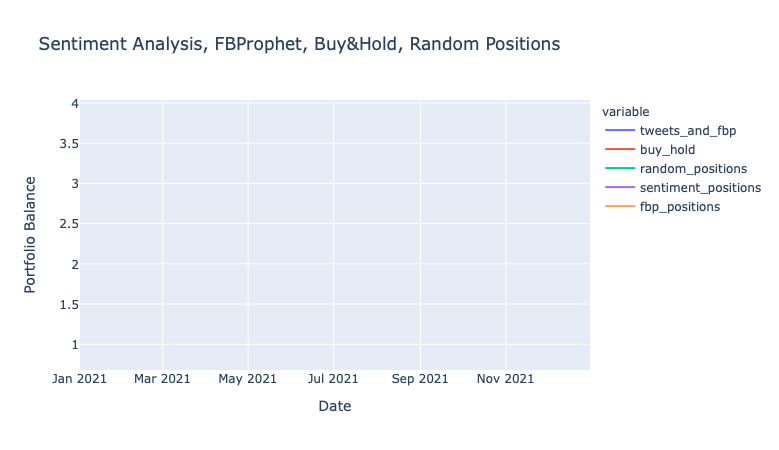

In [217]:
# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='Sentiment Analysis, FBProphet, Buy&Hold, Random Positions',
    labels={"value": "Portfolio Balance",
            "index": "Date"}
)

fig.show()